<h2 style='text-align:center'><b> US Airlines Customer Sentimen Analysis and Classification</b></h1>
<h5 style="text-align: center;"> Ilham Taufieq Julfianto       - JCDS-0410-002</h2>

<a id="numerical"></a>
# <b>Section 1 |</span> Business Problem Understanding</span></b>

### **Company Overview**

The analysis focuses on major US airlines, which are constantly under the public eye due to the vast number of passengers they serve daily. The airlines analyzed include well-known brands, each with its unique challenges and customer service standards. Understanding public sentiment toward these airlines is essential for improving service quality and customer loyalty.


### **Problem Statement**
Airlines receive thousands of tweets daily, reflecting the diverse experiences of their passengers. While some tweets praise the service, others highlight dissatisfaction, particularly regarding delays, customer service, and baggage handling. This analysis aims to identify common issues and gauge the overall sentiment toward these airlines.

### **Objective**

The primary objective of this analysis is to categorize and quantify the sentiment expressed in tweets about US airlines. By understanding the prevalent sentiments and their underlying causes, airlines can take targeted actions to improve their services, address customer pain points, and enhance their market position.

<a id="numerical"></a>
# <b>Section 2 |</span> Data Understanding</span></b>


In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import json
import warnings

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from mlxtend.plotting import plot_confusion_matrix

# Text Processing (NLTK)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Scikit-learn: Model Building and Evaluation
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin

# Miscellaneous
from string import punctuation
from collections import Counter

# Suppress warnings
warnings.filterwarnings("ignore")


### **Data Exploration**

In [2]:
df= pd.read_csv('../data/us_airlines.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
print(f'Amount of rows and columns in dataset: {df.shape}')

Amount of rows and columns in dataset: (14640, 15)


In [4]:
df.columns.tolist()

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  float64
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### **Data Cleaning**

In [6]:
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date

In [7]:
tweet_count = df.groupby('tweet_created').size()
tweet_count

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1344
dtype: int64

In [8]:
missing_percentage = (df.isna().sum() * 100 / df.index.size).round(2)
missing_percentage

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [9]:
df.drop(columns=['tweet_coord', 'airline_sentiment_gold', 'negativereason_gold'], inplace=True)

In [10]:
neg_reason = df.groupby('negativereason').size()
neg_reason

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

<a id="numerical"></a>
# <b>Section 3 |</span> Exploratory Data Analysis</span></b>

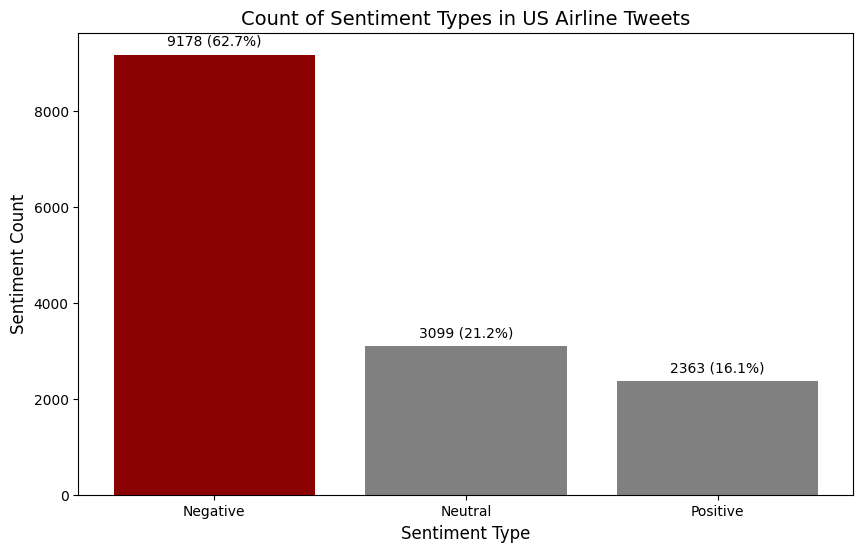

In [11]:
sentiment_counter = df['airline_sentiment'].value_counts()

# Better visualization
index = range(len(sentiment_counter))
colors = ['darkred', 'grey', 'grey']

plt.figure(figsize=(10,6))
plt.bar(index, sentiment_counter, color=colors)
plt.xticks(index, sentiment_counter.index.str.capitalize(), rotation=0)
plt.xlabel('Sentiment Type', fontsize=12)
plt.ylabel('Sentiment Count', fontsize=12)
plt.title('Count of Sentiment Types in US Airline Tweets', fontsize=14)

# Display percentages on bars with gap
for i, value in enumerate(sentiment_counter):
    plt.text(i, value + 200, f'{value} ({value/sum(sentiment_counter)*100:.1f}%)', ha='center', fontsize=10)

plt.show()


**Insight**

**1. Negative Sentiment**: 

- This is the most common sentiment, accounting for approximately 62.7% of all tweets. This indicates that a significant portion of the tweets expresses dissatisfaction or issues with airline services.

**2. Neutral Sentiment**: 

- Neutral sentiments make up about **21.2%** of the tweets. These tweets likely consist of observations or information-sharing without strong positive or negative emotions.

**3. Positive Sentiment**:

- Only about **16.1%** of the tweets are positive, showing that positive experiences are less frequently shared or possibly less common compared to negative ones.

<Axes: xlabel='airline'>

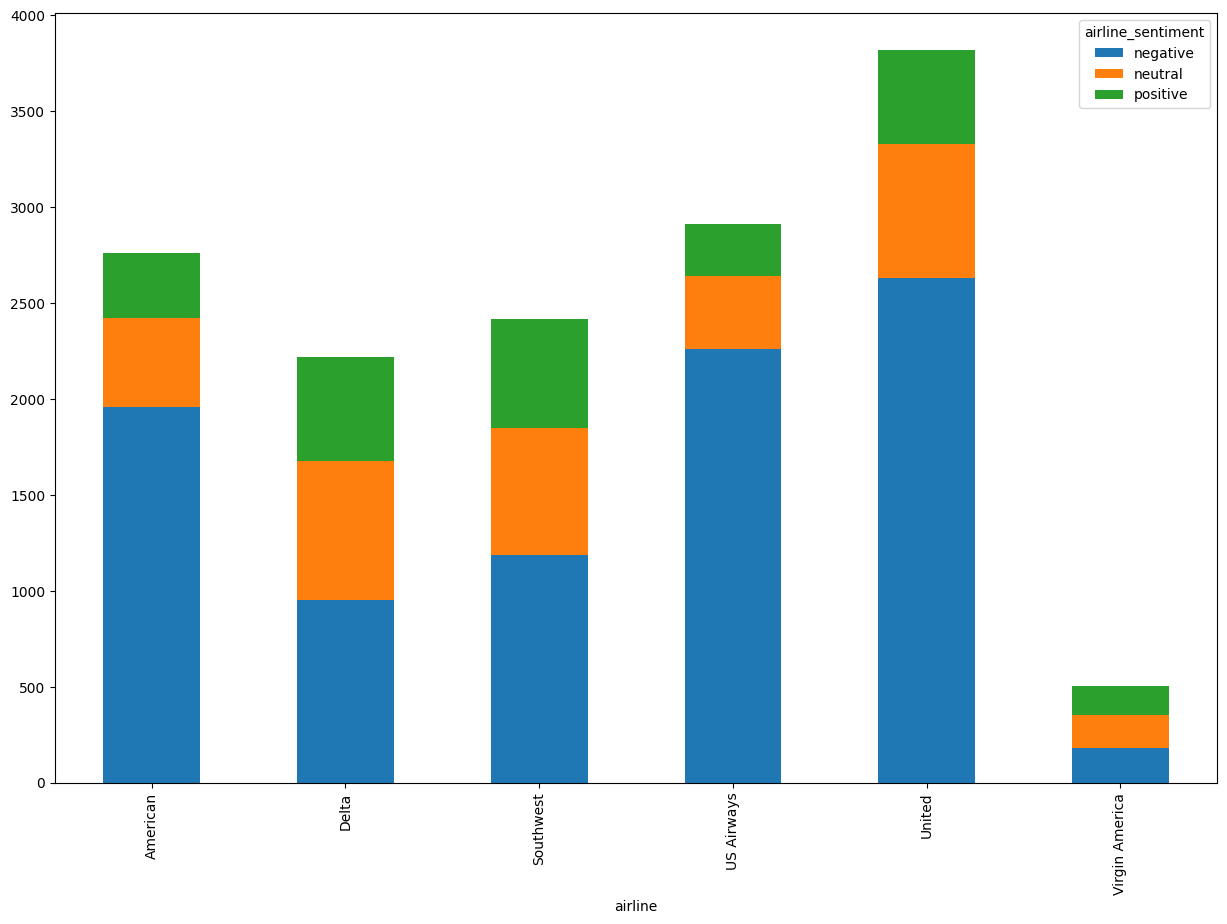

In [12]:
tot_sentiments = df.groupby(['airline', 'airline_sentiment']).size()
tot_sentiments.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

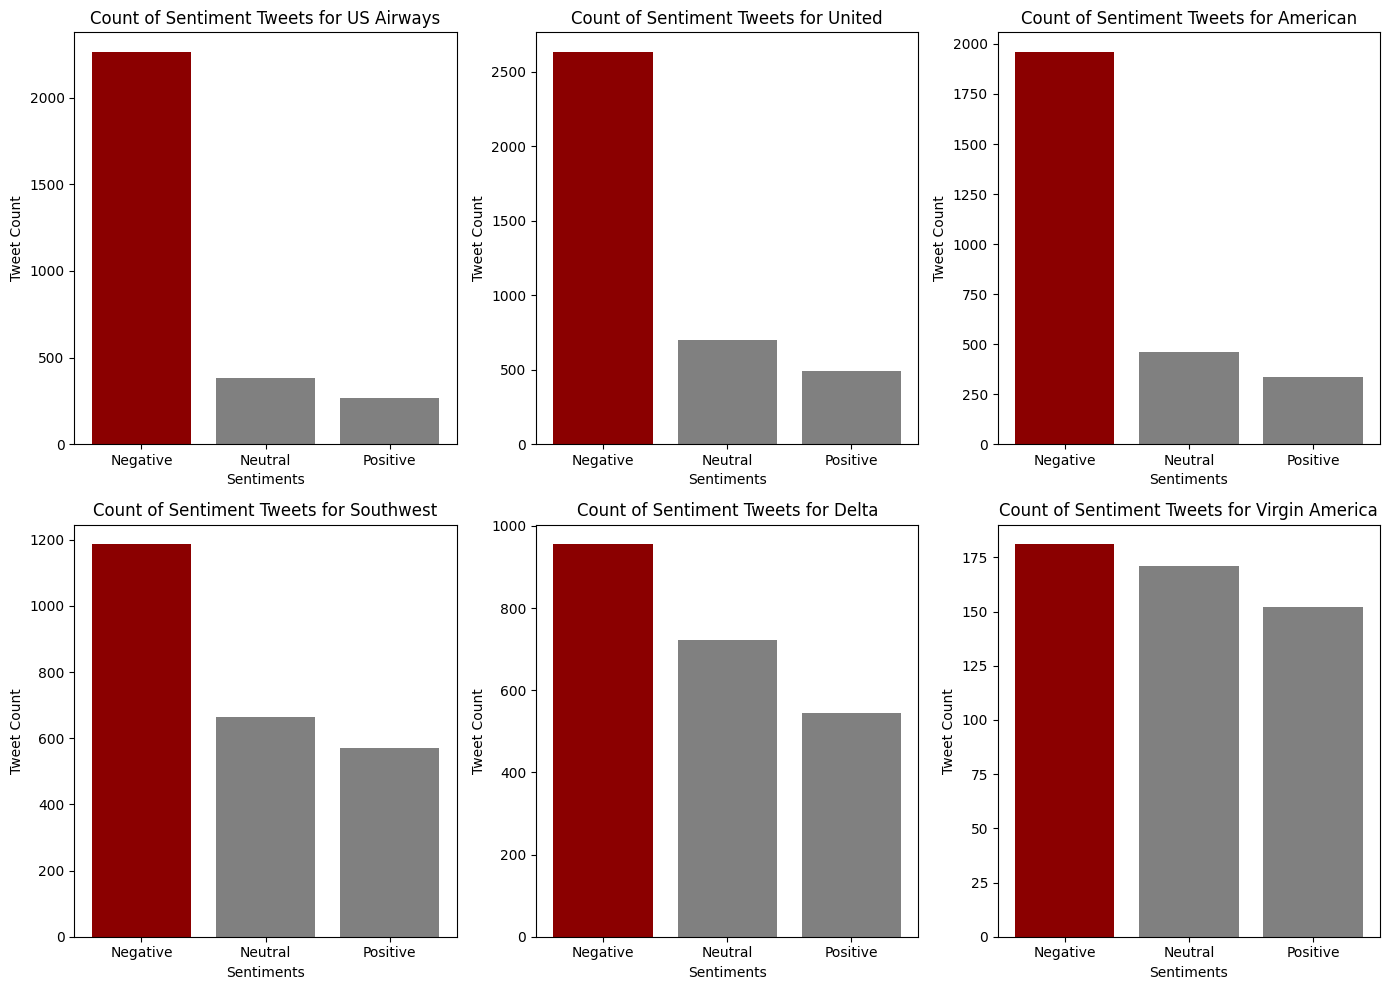

In [13]:
airlines = ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1, figsize=(14, 10))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices+1)
    new_df = df[df['airline'] == i]
    count = new_df['airline_sentiment'].value_counts().reindex(['negative', 'neutral', 'positive'], fill_value=0)
    Index = range(len(count))
    
    bars = plt.bar(Index, count, color=['darkred', 'grey', 'grey'])
    plt.xticks(Index, ['Negative', 'Neutral', 'Positive'])
    plt.ylabel('Tweet Count')
    plt.xlabel('Sentiments')
    plt.title('Count of Sentiment Tweets for ' + i)
    
plt.tight_layout()
plt.show()


**Insight**:

**1. Dominance of Negative Sentiment**:

- Across most airlines, negative sentiment dominates, particularly for airlines like **United** and **US Airways**. This indicates that a significant portion of customers are dissatisfied with their experiences with these airlines.

**2. Neutral Sentiment Variation:**

- Neutral sentiments are relatively consistent across all airlines, but they are particularly prominent in **Virgin America** and **Delta**. This could suggest that while these airlines do have issues, a significant number of interactions don't evoke strong emotions, either positive or negative.

**3. Positive Sentiment as a Minority**:

- Positive sentiments are the least common across all airlines, with Virgin America showing slightly better positive sentiment compared to others. This indicates that positive customer experiences are either less frequent or less likely to be shared online.

**4. Virgin America’s Better Sentiment Balance**:

- **Virgin America** stands out slightly with a more balanced sentiment distribution, having fewer negative tweets compared to other airlines. This suggests that **Virgin America** might be performing relatively better in customer satisfaction.

**5. Implications for Airlines**:

- **United** and **US Airways** might need to prioritize improving their customer service and addressing common complaints, as they have a significantly higher number of negative tweets.

- Airlines with higher neutral sentiment may benefit from engaging more with their customers to convert neutral experiences into positive ones.

- Given the lower number of positive sentiments across the board, all airlines could focus on creating more memorable and positive customer experiences, as well as encouraging satisfied customers to share their experiences online.

<Figure size 2200x1200 with 0 Axes>

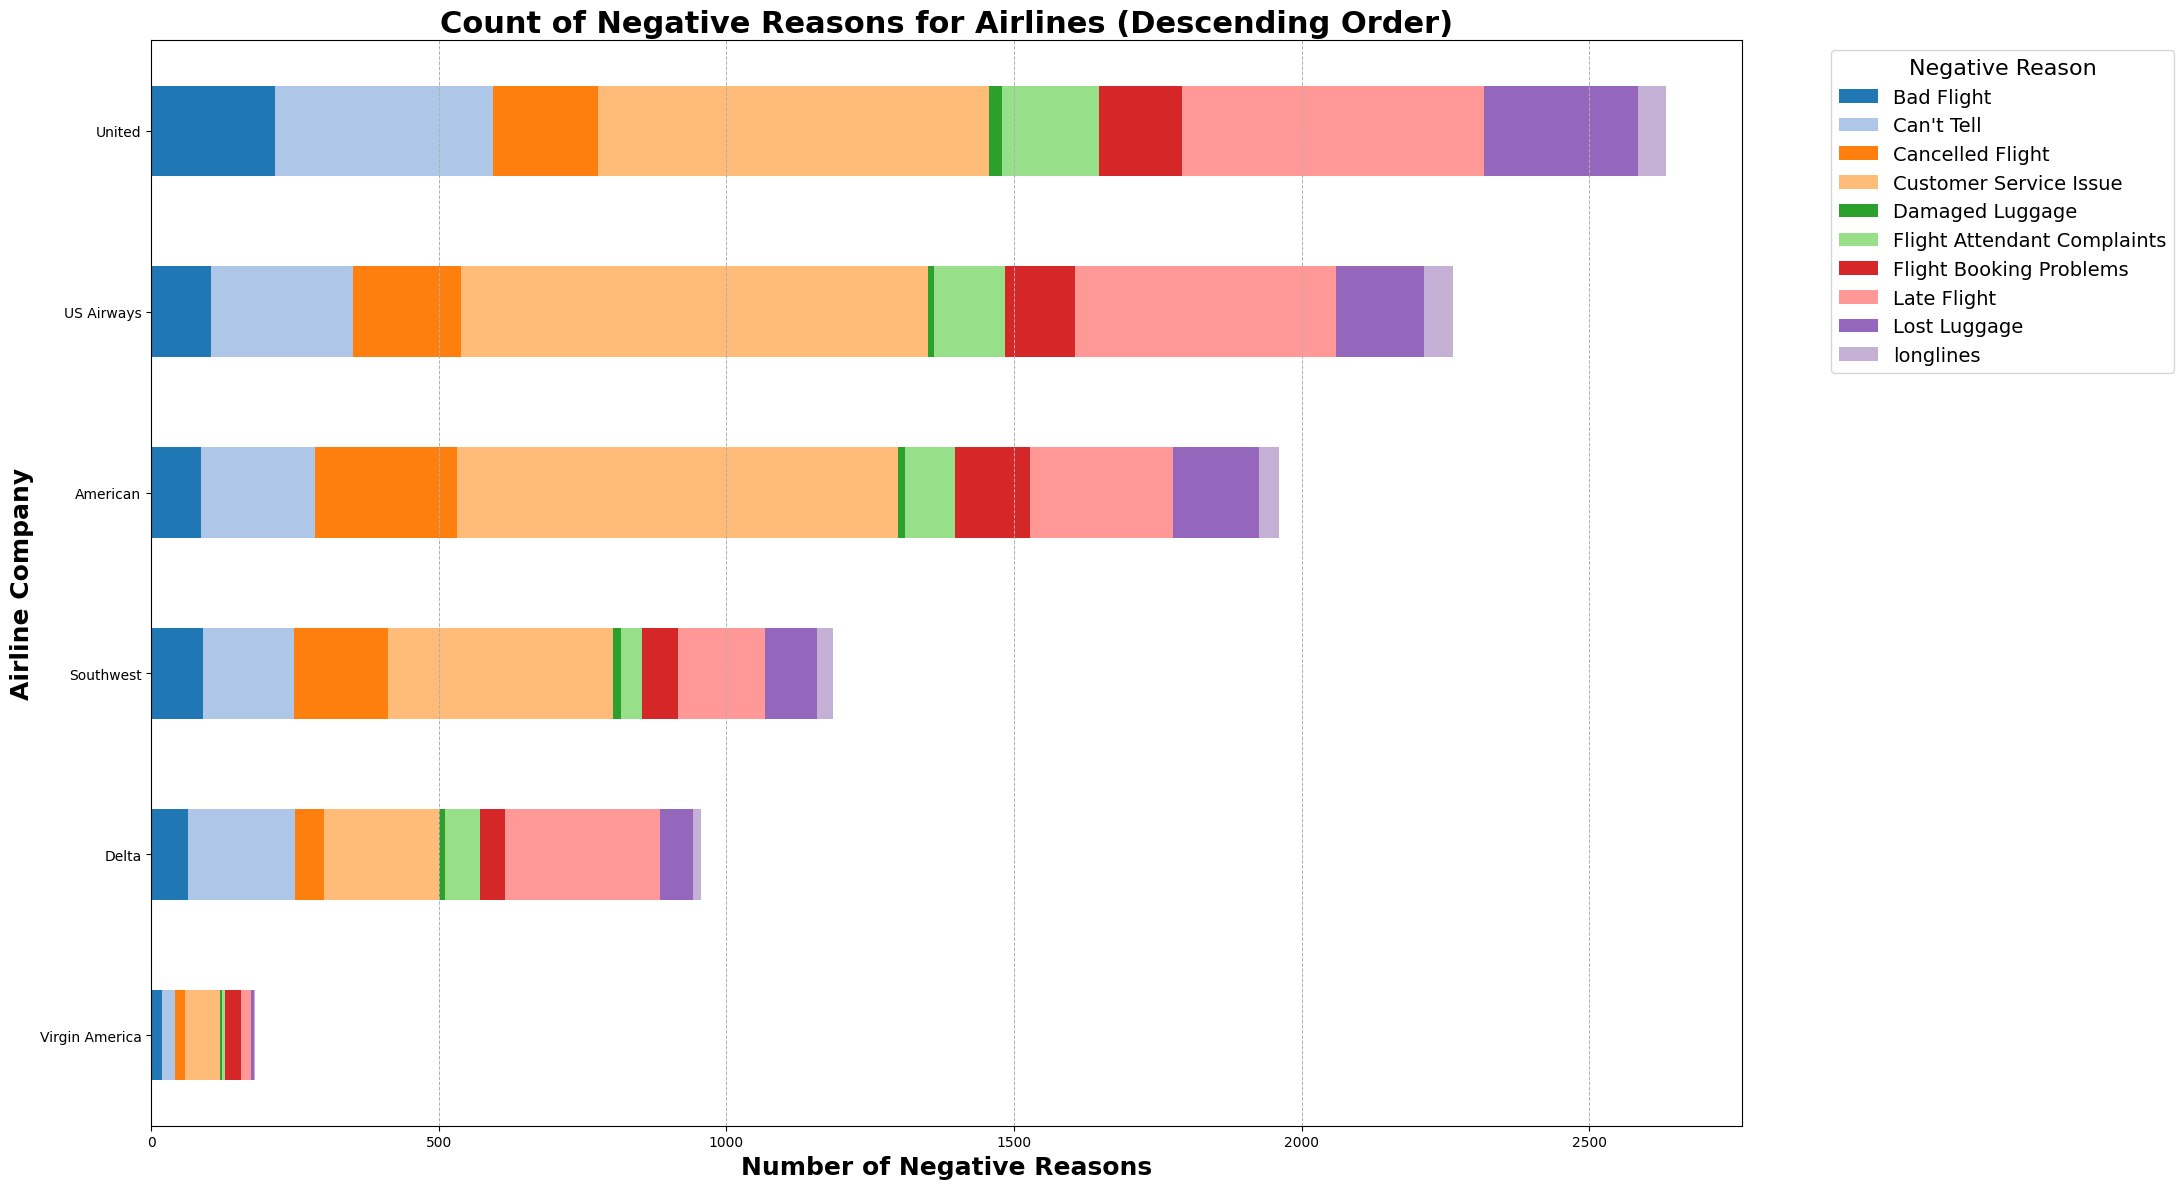

In [14]:
# Group the data by airline and negative reason
negative_reasons = df.groupby('airline')['negativereason'].value_counts(ascending=False)

# Summing the values to sort the airlines by the total number of negative reasons
negative_reasons_sum = negative_reasons.groupby('airline').sum().sort_values(ascending=True)

# Reorder the airlines based on the descending total count of negative reasons
negative_reasons_sorted = negative_reasons.groupby(['airline', 'negativereason']).sum().unstack().loc[negative_reasons_sum.index]

# Create a plot with enhancements
plt.figure(figsize=(22, 12))
ax = negative_reasons_sorted.plot(
    kind='barh',  # Use horizontal bars
    stacked=True,  # Stack the bars
    figsize=(22, 12),
    color=sns.color_palette("tab20", len(df['negativereason'].unique()))  # Enhanced color palette
)

# Title and labels with enhanced formatting
plt.title("Count of Negative Reasons for Airlines (Descending Order)", fontsize=22, fontweight='bold')
plt.xlabel('Number of Negative Reasons', fontsize=18, fontweight='bold')
plt.ylabel('Airline Company', fontsize=18, fontweight='bold')

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', linewidth=0.7)

# Adjust legend placement
plt.legend(title='Negative Reason', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

# Increase spacing for readability
plt.tight_layout()

# Show plot
plt.show()


**Insight**

**1. Customer Service Issues Are Pervasive**:

- Across all airlines, **Customer Service Issues** (represented by the orange bars) dominate the negative sentiment. This suggests that customer service is a major pain point for travelers, and it is a critical area where airlines could focus their improvement efforts.

**2. Airline-Specific Issues**:

- **American Airlines**: Aside from customer service issues, Late Flights (red bars) and Cancelled Flights (pink bars) are also significant contributors to negative sentiment.

- **Southwest**: Customer Service Issues are predominant, but Late Flights are also a notable concern.

- **Delta**: While customer service issues remain significant, Late Flights and Cancelled Flights are also relatively high. However, Bad Flight experiences (blue bars) are more frequently cited here compared to other airlines.

- **United Airlines**: Similar to others, customer service dominates, but Late Flights are also a significant problem.

- **Virgin America**: Interestingly, Customer Service Issues are somewhat less dominant compared to other airlines, with Late Flights and Cancelled Flights also being significant contributors.

**3. Variability in Issue Frequency**:

- The proportion of different negative reasons varies significantly between airlines. For example, Cancelled Flights are a more prominent issue for **Delta** and **Virgin America** compared to Southwest and **US Airways**.

- F**light Attendant Complaints** (green bars) are relatively less frequent across all airlines, but they are more pronounced for **Virgin America**.

**4. Impact of Specific Issues**:

- **Lost Luggage and Damaged Luggage** (purple and dark green bars) are less frequently mentioned overall but still present notable issues for some airlines, particularly Southwest and United.

- **Flight Booking Problems** (represented by light green bars) are a small percentage of the complaints but can still be significant for customer dissatisfaction.

In [15]:
date = df.reset_index()
date.tweet_created = pd.to_datetime(date.tweet_created)
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()

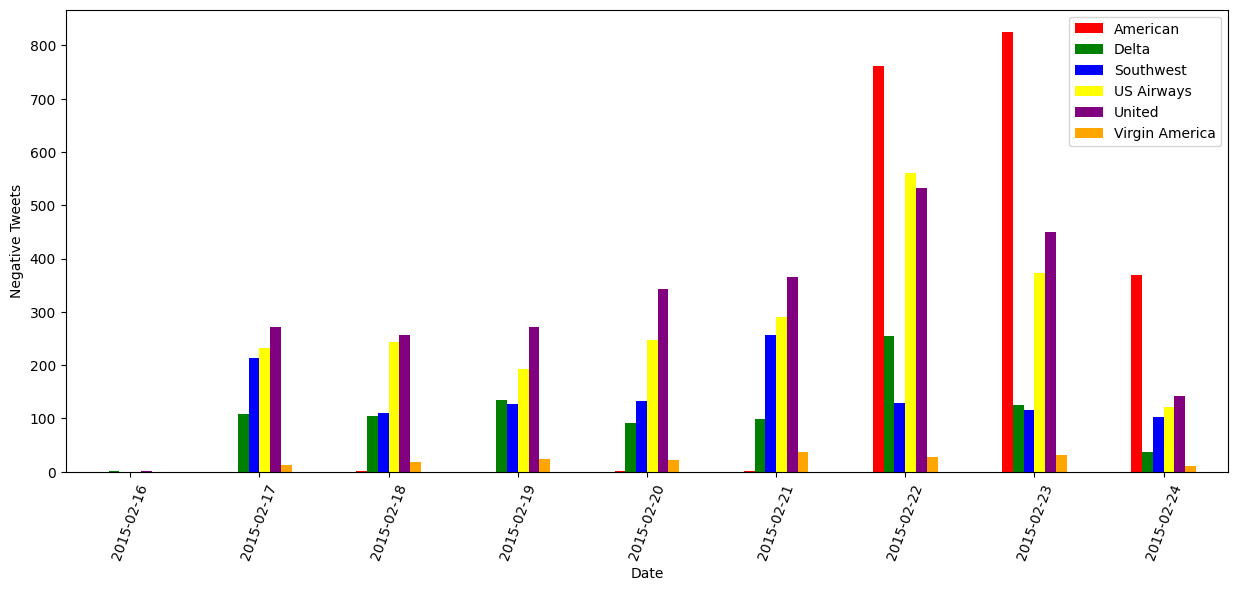

In [16]:
day_df = day_df.loc(axis=0)[:,:,'negative']

ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

**Insight**

**1. Date-Specific Spikes in Negative Sentiment**:

- There are significant spikes in negative tweets on specific dates, particularly on February 22nd and 23rd, 2015.

- American Airlines experienced the highest number of negative tweets on these dates, with numbers exceeding 800 tweets on February 22nd. This suggests that something specific likely happened on these days to trigger a large volume of negative sentiment, such as a widespread service disruption or a major event impacting the airline's operations.

- United Airlines also saw a noticeable increase in negative tweets during the same period, though not as pronounced as American Airlines.

**2. Airline-Specific Trends**:

- American Airlines consistently has the highest number of negative tweets across most days in the observed period. This indicates that customers of American Airlines were particularly vocal about their dissatisfaction during this timeframe.

- United Airlines generally follows a similar pattern to American, with significant numbers of negative tweets, particularly on February 20th, 22nd, and 23rd.

- Southwest and US Airways also experience notable numbers of negative tweets, but these are generally lower than those for American and United.

**3. Relative Stability in Other Airlines**:

- Virgin America and Delta show relatively lower and more stable levels of negative tweets throughout the observed period. This might suggest that these airlines either had fewer operational issues or that their customer service responses were more effective in mitigating negative sentiment.

**4. Potential Causes**:

- The significant spikes in negative tweets on certain days, especially for American Airlines, suggest that there might have been specific incidents or broader operational issues that led to customer dissatisfaction. These could include:

    - Flight cancellations or delays.

    - System outages affecting booking, check-in, or customer support.
    
    - Negative media coverage or public relations issues.

**5. Impact on Brand Perception**:
- The high volume of negative tweets, particularly concentrated on certain days, could have a substantial impact on the public perception of the airlines involved, especially American Airlines and United Airlines. If not addressed properly, these spikes could lead to longer-term damage to their brand reputation.

<a id="numerical"></a>
# <b>Section 4 |</span> Text Exploration</span></b>

### **Text Preprocessing**

In [17]:
def toLower(text):
    return text.lower()

def toLowerColumn(df, column_name):
    df[column_name] = df[column_name].apply(toLower)
    return df

The `toLower` function converts a given string to lowercase using Python's `.lower()` method. It takes one parameter, `text`, and returns the string with all characters in lowercase. This function is useful for standardizing text data, especially in cases where consistent text formatting is important, such as in text processing or comparison tasks.

In [18]:
with open('contractions.json', 'r') as file:
    contraction_list = json.load(file)

In the context of text mining, the `contractions.json` file likely contains a mapping of common contractions (like "don't" or "can't") to their expanded forms ("do not" or "cannot"). The code reads this JSON file into a Python dictionary, which can then be used to expand contractions in text data. Expanding contractions is an important preprocessing step in text mining, as it helps standardize the text, making it easier to analyze and improving the accuracy of tasks like sentiment analysis, tokenization, and natural language processing (NLP).

In [19]:
def expandContractions(text):
    compiler = re.compile('(%s)' % '|'.join(contraction_list.keys()))
    def replace(match):
        return contraction_list[match.group(0)]
    return compiler.sub(replace, text)

The `expandContractions` function is designed to expand contractions in a given text using a predefined dictionary of contractions (`contraction_list`). It works by first compiling a regular expression pattern that matches any contraction found in the text. The function then replaces each contraction in the text with its corresponding expanded form from the `contraction_list` dictionary. This is done using the `sub()` method from the `re` module, which substitutes the matched contractions with their expanded forms, effectively standardizing the text for further analysis in text mining tasks.

In [20]:
def removeNumbers(text):
    output = ''.join(c for c in text if not c.isdigit())
    return output.strip()

The `removeNumbers` function removes all numeric characters from a given text. It does this by iterating through each character in the text, keeping only those that are not digits (c.isdigit() checks if a character is a digit). The resulting string, without numbers, is then returned after stripping any leading or trailing whitespace using .strip().

In [21]:
def removePunctuation(text):
    return ''.join(c for c in text if c not in punctuation)

The `removePunctuation` function is designed to eliminate all punctuation characters from a given text. It uses the punctuation constant from Python's string module, which includes all standard punctuation symbols (like ., ,, !, etc.). The function works by iterating over each character in the input text and constructing a new string that includes only those characters that are not punctuation. This is done using a generator expression inside the join method, which efficiently filters out the unwanted punctuation.

In [22]:
def removeStopwords(sentence):
    stop_words = stopwords.words('english')
    return ' '.join([w for w in nltk.word_tokenize(sentence) if not w in stop_words])

The `removeStopwords` function removes common stopwords from a sentence, leaving only the more meaningful words. It uses NLTK to tokenize the sentence and filter out any words that are found in the stopwords list. This process is essential in text preprocessing to focus on the significant words that contribute to the meaning of the text.

In [23]:
def stem(text):
    stemmer = SnowballStemmer('english')
    stemmed_word = [stemmer.stem(word) for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
    return " ".join(stemmed_word)

The `stem` function applies stemming to each word in the input text, reducing words to their root forms (e.g., "running" becomes "run"). It uses NLTK's SnowballStemmer for English, which helps in normalizing the text by treating related words as the same. 

In [24]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_word = [lemmatizer.lemmatize(word) for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
    return " ".join(lemmatized_word)

The `lemmatize` function processes text by converting each word to its base or dictionary form using NLTK's `WordNetLemmatizer`. This technique, called lemmatization, is useful for normalizing text data by reducing words to their canonical forms (e.g., "better" becomes "good"). Unlike stemming, lemmatization ensures that the resulting base form is a valid word in the language. 

In [25]:
def toLower(X):
    return X.apply(lambda x: x.lower())

def removeNumbers(X):
    return X.apply(lambda x: ''.join(c for c in x if not c.isdigit()))

def removePunctuation(X):
    return X.apply(lambda x: ''.join(c for c in x if c not in punctuation))

def expandContractions(X):
    compiler = re.compile('(%s)' % '|'.join(contraction_list.keys()))
    def replace(match):
        return contraction_list[match.group(0)]
    return X.apply(lambda x: compiler.sub(replace, x))

def removeStopwords(X):
    stop_words = stopwords.words('english')
    return X.apply(lambda x: ' '.join([w for w in nltk.word_tokenize(x) if not w in stop_words]))

def lemmatize(X):
    lemmatizer = WordNetLemmatizer()
    return X.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for sent in nltk.sent_tokenize(x)for word in nltk.word_tokenize(sent)]))

After all function are settled, we will collect them

In [26]:
df['text_clean'] = (
    df['text']
    .pipe(toLower)
    .pipe(removeNumbers)
    .pipe(removePunctuation)
    .pipe(expandContractions)
    .pipe(removeStopwords)
    .pipe(lemmatize)
)
df

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,text_clean
0,0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN,Eastern Time (US & Canada),virginamerica dhepburn said
1,1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercial expe...
2,2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada),virginamerica didnt today must mean need take ...
3,3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...
4,4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada),virginamerica really big bad thing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,14635,5.695877e+17,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22,NaN,NaN,americanair thank got different flight chicago
14636,14636,5.695874e+17,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22,Texas,NaN,americanair leaving minute late flight warning...
14637,14637,5.695872e+17,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22,"Nigeria,lagos",NaN,americanair please bring american airline blac...
14638,14638,5.695872e+17,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22,New Jersey,Eastern Time (US & Canada),americanair money change flight dont answer ph...


After that, input them in a pipeline that has output `text_clean` column

### **Text Exploration**

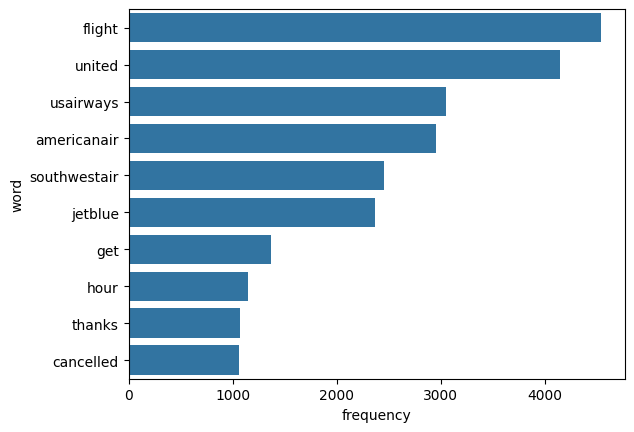

In [27]:
def word_freq(text, ngram):
    tokens = word_tokenize(text)
    return [' '.join(gram) for gram in list(ngrams(tokens, ngram))]
    
# Apply the function to the message column
df['tokens'] = df['text_clean'].apply(lambda x: word_freq(x, 1))

# Calculate word frequencies
all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Convert word frequencies to a DataFrame
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Show
sns.barplot(x='frequency', y='word', data=freq_df.head(10))
plt.show()

This code processes cleaned text data in a DataFrame to generate and analyze word frequencies. It starts by tokenizing the text into individual words (or n-grams if desired) and then counts the frequency of each word across the entire dataset. The resulting word frequencies are stored in a DataFrame, which is then used to create a bar plot displaying the top 10 most common words. This visualization helps in understanding the most frequent terms in the text, which can be useful for text analysis tasks such as identifying key themes or features in the data.

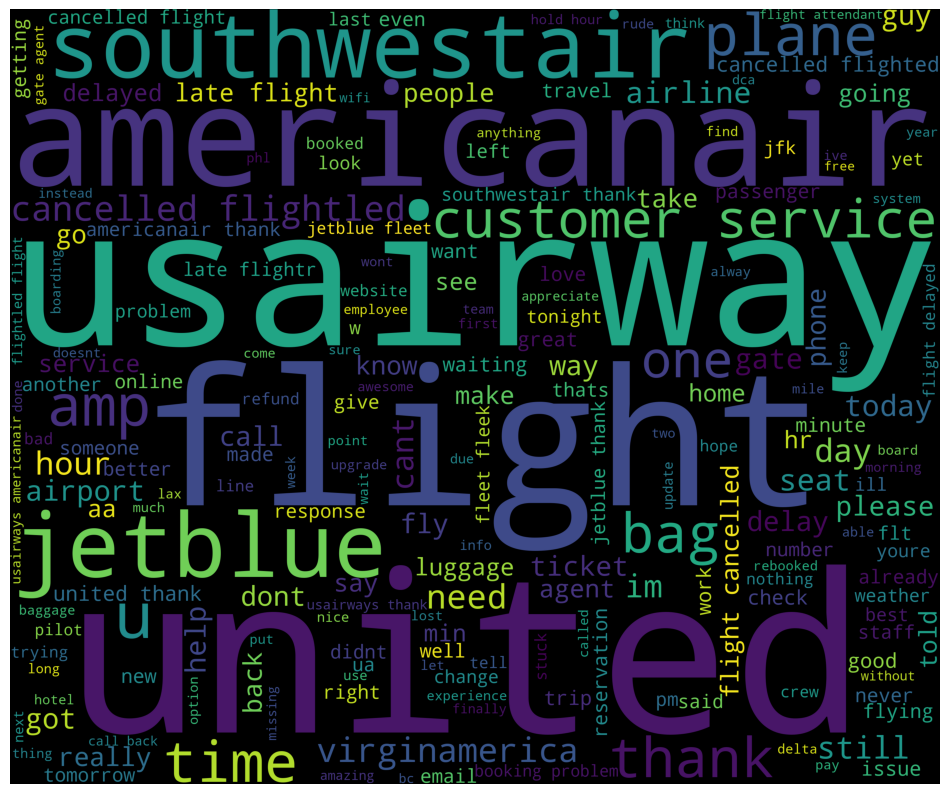

In [240]:
positive_wordcloud=df[df['airline_sentiment']=='positive']
words = ' '.join(df['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

This word cloud provides a visual summary of the most common words in positive sentiment, likely tweets or comments related to airlines. The largest words, such as "united," "americanair," and "flight," indicate frequent topics or entities discussed, with a focus on customer service, delays, cancellations, and other flight-related issues.

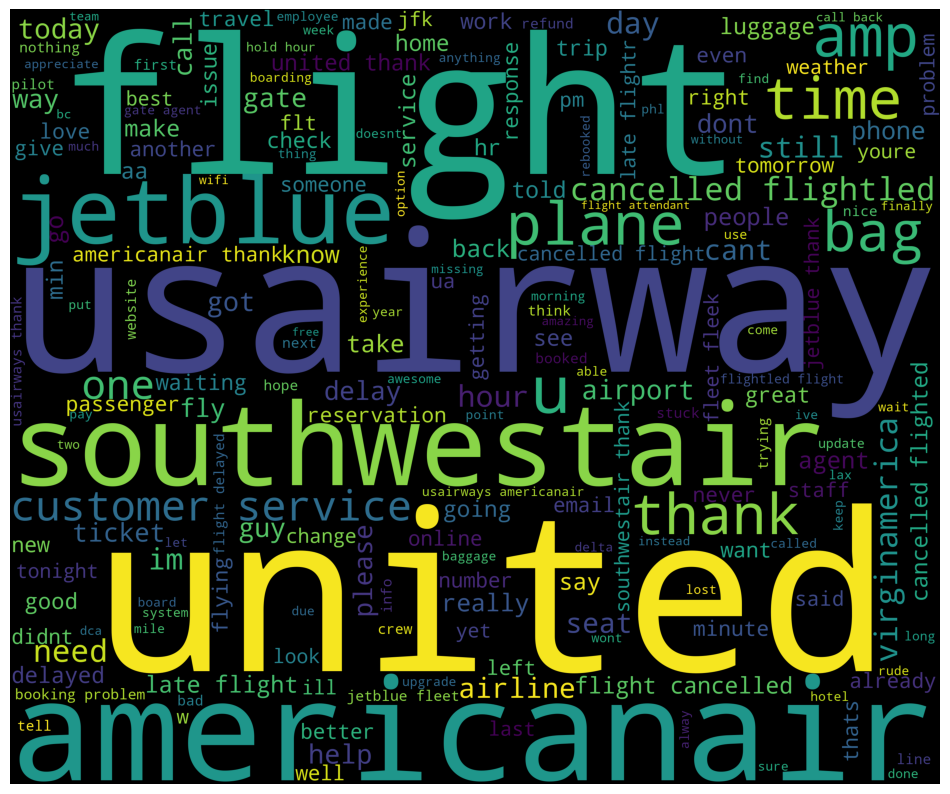

In [241]:
negative_wordcloud=df[df['airline_sentiment']=='negative']
words = ' '.join(df['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

This word cloud visually summarizes the most common topics and concerns expressed in negative sentiment data related to airlines. The large size of words like "americanair," "usairway," "flight," "cancelled," and "service" indicates that these are frequent points of discussion. The word cloud highlights key issues such as flight delays, cancellations, poor customer service, and baggage problems.

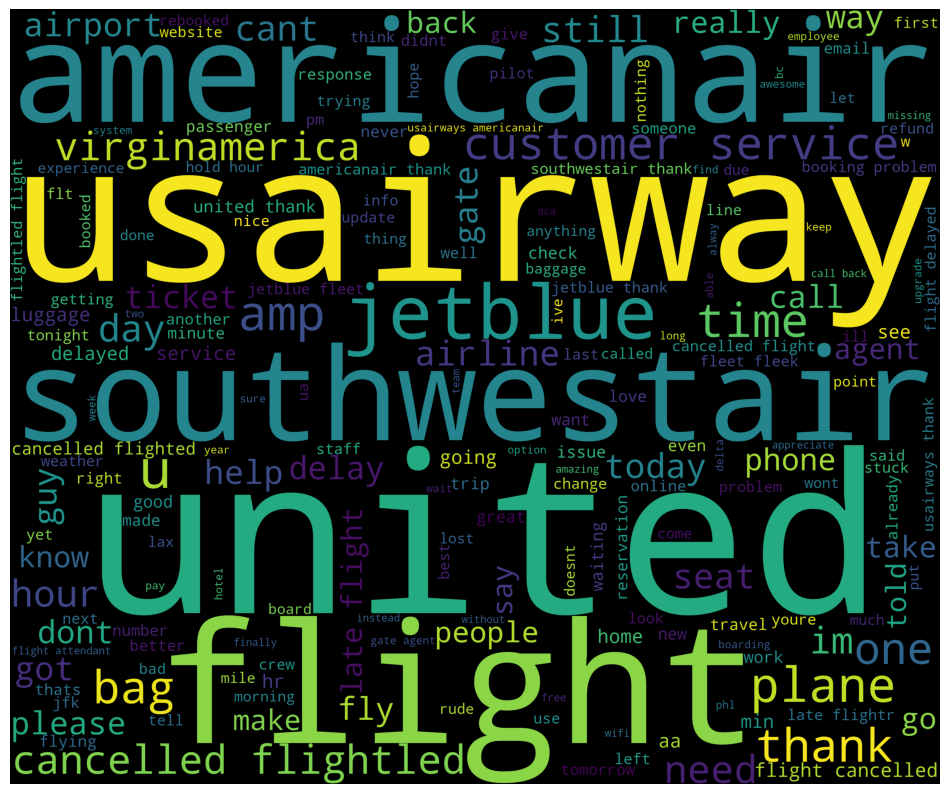

In [242]:
neutral_wordcloud=df[df['airline_sentiment']=='neutral']
words = ' '.join(df['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

This word cloud provides a visual summary of the most common words in neutral sentiment data related to airlines. The large size of words like "americanair," "usairway," "flight," and "service" suggests these are frequently mentioned topics. The focus is on reporting or discussing aspects of air travel such as flight status, customer service, and logistics without expressing a strong positive or negative opinion. 

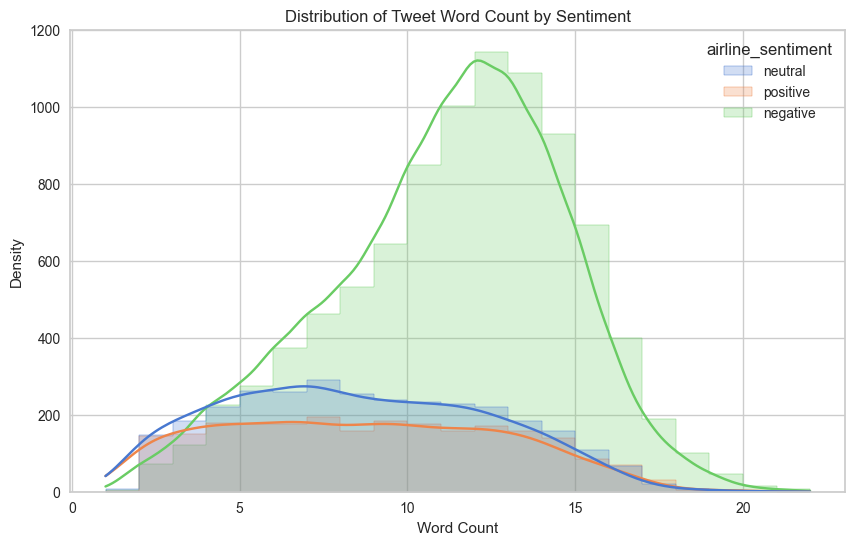

In [243]:
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))

# Create a histogram with KDE for word count, split by sentiment
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="word_count", hue="airline_sentiment", kde=True, element="step", binwidth=1, palette="muted")

# Add a title and labels for clarity
plt.title('Distribution of Tweet Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Show plot
plt.show()

**Insight**

**1. Negative Sentiment Tweets Are Longer**:

- The distribution for negative sentiment tweets (green curve) shows that these tweets tend to have higher word counts, typically between 10 and 15 words. This suggests that users expressing negative sentiments are more likely to use longer messages, possibly because they want to explain or elaborate on their complaints or frustrations. This longer word count could be indicative of the need to fully describe issues or dissatisfaction.

**2. Neutral Sentiment Tweets Have Moderate Length**:

- The neutral sentiment tweets (blue curve) exhibit a relatively flat distribution, with a slight peak around 7 to 10 words. This indicates that neutral tweets are generally of moderate length, neither too short nor too long. These tweets might include factual statements, updates, or other non-emotional content that doesn’t require extensive elaboration.

**3. Positive Sentiment Tweets Are Shorter**:

- Positive sentiment tweets (orange curve) tend to be shorter, usually containing between 5 and 10 words. The density of positive tweets is lower overall, suggesting that users expressing positive sentiment often do so concisely. This could be because positive feedback or compliments are often brief and to the point, such as "Great service!" or "Love this airline!"

**4. Different Communication Styles Based on Sentiment:**

- The differences in word count distribution across sentiments highlight how users adjust their communication style depending on the sentiment they wish to express. Negative sentiments often involve more detailed explanations, while positive sentiments are more likely to be expressed in brief, direct statements. Neutral sentiments fall somewhere in between, potentially reflecting a balance between providing information and being concise.

<a id="numerical"></a>
# <b>Section 5 |</span> Text Classification</span></b>

In [244]:
class TextCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        # No fitting necessary, so we just return self
        return self
        
    def transform(self, X, y=None):
        # Return text that has been cleaned
        X = (X.pipe(toLower)
            .pipe(removeNumbers)
            .pipe(removePunctuation)
            .pipe(expandContractions)
            .pipe(removeStopwords)
            .pipe(lemmatize)
        )
        return X

In [245]:
# Split the dataset into feature and target
text = df['text']

label = np.where(df['airline_sentiment'] == 'positive', 1, np.where(df['airline_sentiment'] == 'negative', 0, np.where(df['airline_sentiment'] == 'neutral', 2, 3)))

# Split the dataset into training and test sets
text_train, text_test, label_train, label_test = train_test_split(text, label, stratify=label)

In [246]:
# Define the pipeline
pipe_A = Pipeline([
    ('cleaning', TextCleaning()),
    ('dtm', TfidfVectorizer(norm=None, ngram_range=(1, 1), use_idf=True)),
    ('model', SVC(kernel='linear', random_state = 42))
])

# # Define the parameter grid
param_grid_svm = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__class_weight': [None, 'balanced'],
    'model__gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid = RandomizedSearchCV(pipe_A, param_grid_svm, cv=7)

# Fit GridSearchCV to the training data
grid.fit(text_train, label_train)

RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('cleaning', TextCleaning()),
                                             ('dtm',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                              ngram_range=(1,
                                                                           1),
                                                              norm=None,
                                                              preprocessor=None,
                                                              smooth_id...
                                                  random_state=42,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   n_iter=10, n_jobs=None,
                   param_distributions={'model__C': [0.01, 0.1, 1, 10, 100],
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['linear', 'rbf',
                                                          'poly']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

**Breakdown of the Pipeline Components**:

**1. TextCleaning**:

- The pipeline begins with a custom `TextCleaning` step, which is likely a class or function that performs various text preprocessing tasks. These tasks might include converting text to lowercase, removing punctuation, expanding contractions, removing stopwords, and lemmatizing words. The purpose of this step is to standardize and clean the raw text data, making it suitable for further processing.

**2. TfidfVectorizer**:

- After text cleaning, the processed text is passed to a `TfidfVectorizer`. This component converts the cleaned text into numerical features using the Term Frequency-Inverse Document Frequency (TF-IDF) method. TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). In this case, the norm=None parameter suggests that no normalization is applied to the resulting vectors.

**3. Support Vector Classifier (SVC)**:

- The final step in the pipeline is the SVC model, which is a type of Support Vector Machine (SVM) classifier. The model uses a linear kernel (kernel='linear'), meaning it seeks to find a linear boundary that best separates the classes in the feature space. The random_state=42 parameter ensures reproducibility by setting a seed for the random number generator.

**4. RandomizedSearchCV**:

- The pipeline is wrapped in RandomizedSearchCV, which is used for hyperparameter optimization. RandomizedSearchCV searches over a specified number of hyperparameter combinations from a predefined set, rather than exhaustively searching over all possible combinations (as in GridSearchCV). This approach is faster and often sufficient to find a good set of hyperparameters.

In [247]:

# Finalize the best model
grid.best_estimator_.fit(text_train, label_train)

# Predict using the best model
label_pred = grid.best_estimator_.predict(text_test)

# Evaluate the model
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2294
           1       0.75      0.64      0.69       591
           2       0.62      0.54      0.58       775

    accuracy                           0.78      3660
   macro avg       0.73      0.69      0.71      3660
weighted avg       0.77      0.78      0.77      3660



**Insight**

- The model performs best on class 0, with high precision, recall, and F1-score.

- Performance drops for class 1 and is notably lower for class 2, where the model has difficulty correctly identifying instances.

- The overall accuracy is 78%, which is respectable but indicates room for improvement, particularly in handling the minority classes (1 and 2).

- The macro average and weighted average scores give a balanced view of the model’s performance across all classes, with the weighted average being slightly higher due to the dominance of class 0.

In [249]:
# Define the pipeline
pipe = Pipeline([
    ('cleaning', TextCleaning()),
    ('dtm', TfidfVectorizer(norm=None, ngram_range=(1, 1), use_idf=True)),
    ('model', LogisticRegression())
])

# Define the parameter grid
param_grid = {'model__C': [0.01, 0.1, 1, 10, 100], 'model__class_weight': [None, 'balanced']}

# Initialize GridSearchCV
grid = RandomizedSearchCV(pipe, param_grid, cv=7)

# Fit GridSearchCV to the training data
grid.fit(text_train, label_train)

RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('cleaning', TextCleaning()),
                                             ('dtm',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                              ngram_range=(1,
                                                                           1),
                                                              norm=None,
                                                              preprocessor=None,
                                                              smooth_id...
                                                                 max_iter=100,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l2',
                                                                 random_state=None,
                                                                 solver='lbfgs',
                                                                 tol=0.0001,
                                                                 verbose=0,
                                                                 warm_start=False))],
                                      verbose=False),
                   n_iter=10, n_jobs=None,
                   param_distributions={'model__C': [0.01, 0.1, 1, 10, 100],
                                        'model__class_weight': [None,
                                                                'balanced']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

**Breakdown of the Pipeline Components**:

**1. TextCleaning**:

- The first step in the pipeline is `TextCleaning`, which is likely a custom function or class designed to preprocess the raw text data. This step might include operations like converting text to lowercase, removing punctuation, expanding contractions, removing stopwords, and lemmatizing words. The goal of this step is to prepare the text data so that it can be effectively transformed into numerical features.

**2. TfidfVectorizer**:
- After text cleaning, the data is passed to a `TfidfVectorizer`. This component transforms the cleaned text into numerical features using the Term Frequency-Inverse Document Frequency (TF-IDF) method. TF-IDF is a widely used technique that converts a collection of raw documents into a matrix of TF-IDF features, which reflect the importance of words relative to the entire corpus.

**3. LogisticRegression**:
- The final step in the pipeline is a `LogisticRegression` model. Logistic Regression is a linear model used for binary or multi-class classification tasks. It predicts the probability that a given input belongs to a particular class. In this pipeline, the Logistic Regression model uses the features generated by the TfidfVectorizer to make predictions.

In [250]:
# Finalize the best model
grid.best_estimator_.fit(text_train, label_train)

# Predict using the best model
label_pred = grid.best_estimator_.predict(text_test)

# Evaluate the model
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2294
           1       0.75      0.68      0.71       591
           2       0.65      0.55      0.59       775

    accuracy                           0.79      3660
   macro avg       0.75      0.71      0.73      3660
weighted avg       0.79      0.79      0.79      3660



**Insight**

- The model performs best on class 0, with high precision, recall, and F1-score.

- Performance on class 1 is moderate, indicating the model is somewhat less effective at correctly identifying and predicting this class.

- The model struggles the most with class 2, showing the lowest precision, recall, and F1-score, indicating challenges in correctly classifying this class.

- The overall accuracy of the model is 79%, with the macro and weighted averages suggesting a generally balanced performance, though the model could be improved, particularly for the minority classes (1 and 2).

<a id="numerical"></a>
# <b>Section 6 |</span> Conclusion and Recommendation</span></b>

### **Conclusion**:

The sentiment analysis conducted on US airline tweets using the dataset provided reveals several key insights. The model developed for text classification, despite being simple and utilizing basic logistic regression, was able to identify negative sentiments with a certain level of accuracy. However, the model struggled significantly with predicting positive sentiments, which indicates that the current setup may not be sufficient for comprehensive sentiment analysis.
The analysis highlighted that negative feedback is more prominent in the dataset, with common issues related to delays, cancellations, and poor customer service. This reflects the real-world challenges airlines face in maintaining customer satisfaction. The findings suggest that while airlines are often the subject of complaints, there is also a presence of positive interactions, although they are less frequently captured by the model.

### **Recommendations**:

**1. Improve Model Performance:**

- Data Augmentation: To enhance the model’s ability to recognize positive sentiments, it is crucial to either collect more data or employ techniques like data augmentation to balance the dataset. A more balanced dataset will help the model better understand the nuances of positive sentiments.

- Advanced Modeling Techniques: Consider exploring more sophisticated models such as ensemble methods (e.g., Random Forest, Gradient Boosting) or deep learning approaches (e.g., LSTM, BERT) that can capture complex patterns in text data more effectively.

**2. Feature Engineering:**

- Improve the text preprocessing steps by incorporating advanced natural language processing (NLP) techniques like word embeddings (e.g., Word2Vec, GloVe) or utilizing context-aware models like BERT to better capture the semantics of the tweets.
Experiment with different vectorization techniques beyond TF-IDF, such as word embeddings, which can better represent the meaning of the words in the context of their usage.

**3. Expand and Diversify the Dataset:**

- For a more comprehensive sentiment analysis, it’s important to gather a larger and more diverse dataset. Including tweets from different time periods, covering various events and seasons, can provide a more accurate reflection of public sentiment toward airlines.
Additionally, consider collecting tweets that explicitly express positive experiences to ensure that the model is exposed to a wider range of sentiments during training.

**4. Real-Time Sentiment Monitoring:**

- Implement the trained model in a real-time sentiment monitoring system to track customer feedback on social media. This would allow airlines to promptly respond to emerging issues and engage with positive feedback, improving customer relations.
Regularly retrain the model with new data to keep it updated with current trends and language usage, which can change over time.

**5. Customer Service Improvement:**

- The insights from this sentiment analysis should be used by airlines to address common customer complaints such as delays and poor service. By focusing on these areas, airlines can potentially reduce the volume of negative sentiment and improve overall customer satisfaction.